# A building classifier with fastai

## Contents
- Overview
- Images
- Train Model
- Evaluate Model
- Conclusions

## Overview

As I am going through the fastai course I am trying out the techniques taught. 
In lesson 2 of their online course: Practical Deep Learning for Coders, v3 (https://course.fast.ai/videos/?lesson=2) they cover, among other things, training a classifier from images downloaded from google images.

Here I have trained a classifier to identify different types of buildings.
I have chosen 7 categories of buildings: apartment building, church, cottage, house, town hall, townhouse, and tree house. I will test it on photos I have taken or downloaded of some of these types of buildings.

## Images

I obtained a list of URLs from google images from the following searches:
- Apartment building
- Church building
- Cottage
- House
- Town hall
- Townhouse
- Tree house

Then I followed their instructions to run Javascript code in my browser to save the URLs of the images:



Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.


```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



Note that I needed to turn of the adblocker to make this work.

The lesson also covered removing images that are not relevant by training the model then using a widget designed to show the images that the model was most uncertain about or that the model had misclassified that could then be deleted. However, the widget does not work on google colab and I couldn't get it to work on my local machine either, so I have just left all images and hopefully the incorrect images don't affect the classifier too much.

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
classes = ['apartment_building','church', 'cottage', 'house', 'town_hall', 'townhouse', 'tree_house']

In [0]:
path = Path('data/buildings')

In [0]:
import shutil
import os
if not os.path.exists('./data/buildings'):
    os.mkdir('./data')
    os.mkdir('./data/buildings')
    shutil.copyfile('apartment_building.txt', './data/buildings/apartment_building.txt')
    shutil.copyfile('church.txt', './data/buildings/church.txt')
    shutil.copyfile('cottage.txt', './data/buildings/cottage.txt')
    shutil.copyfile('house.txt', './data/buildings/house.txt')
    shutil.copyfile('town_hall.txt', './data/buildings/town_hall.txt')
    shutil.copyfile('townhouse.txt', './data/buildings/townhouse.txt')
    shutil.copyfile('tree_house.txt', './data/buildings/tree_house.txt')


In [0]:
for c in classes:
    print(c)
    folder = c
    file = c + '.txt'
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=200)

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [82]:
data.classes

['apartment_building',
 'church',
 'cottage',
 'house',
 'town_hall',
 'townhouse',
 'tree_house']

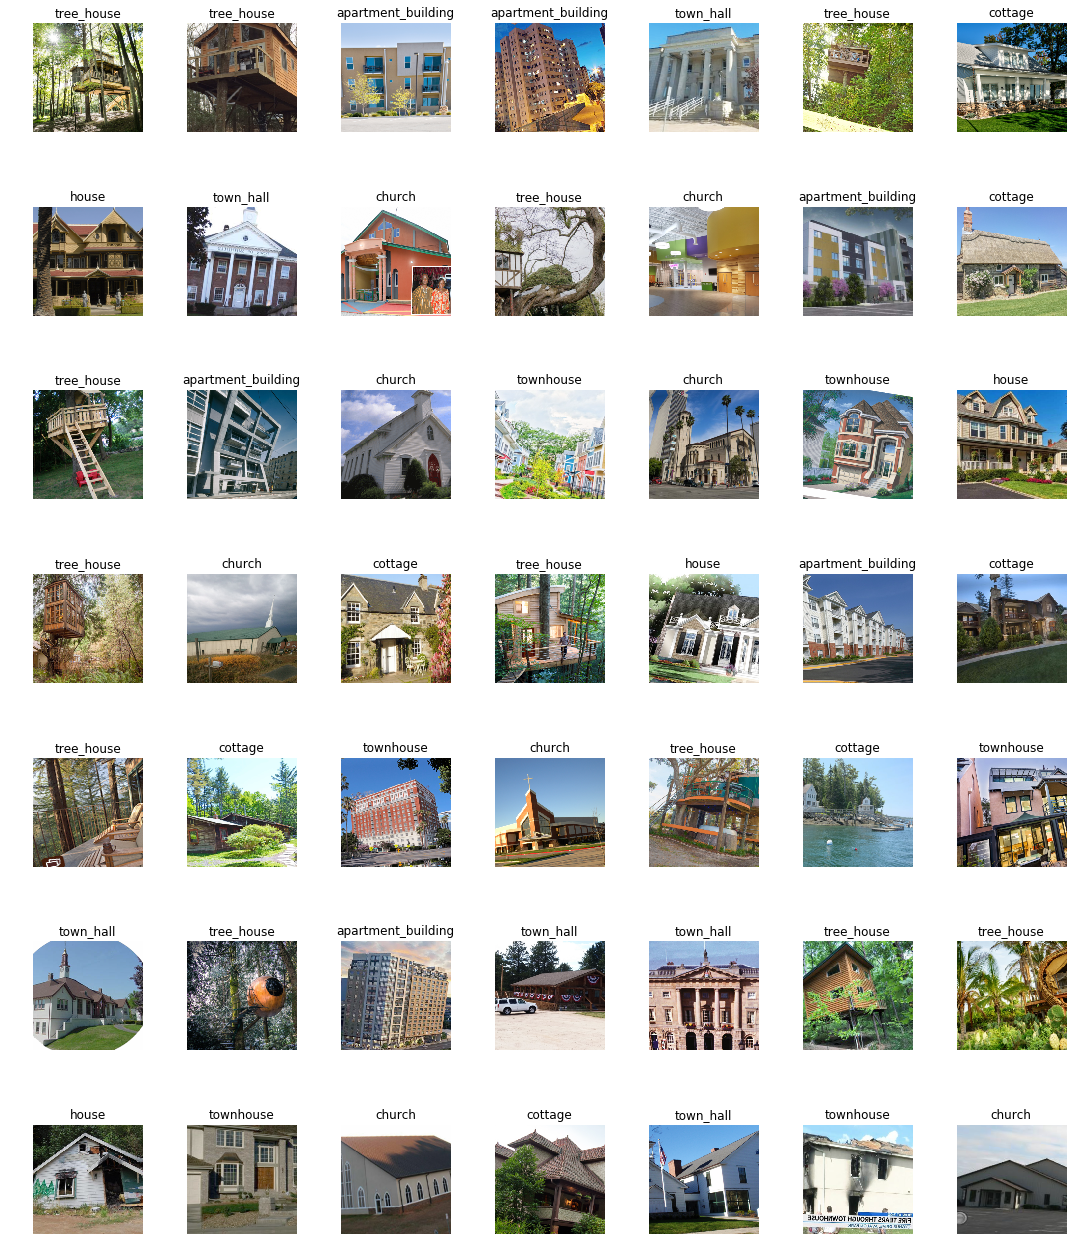

In [83]:
data.show_batch(rows=7, figsize=(15,18))

In [84]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['apartment_building',
  'church',
  'cottage',
  'house',
  'town_hall',
  'townhouse',
  'tree_house'],
 7,
 1020,
 254)

## Train Model

Use a pretrained ResNet34 model with classifier layers.
Train for 8 epochs using cyclic learning rate.
Train for an additional 4 epochs using cyclic learning rate with all layers.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [86]:
learn.fit_one_cycle(8)

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [89]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


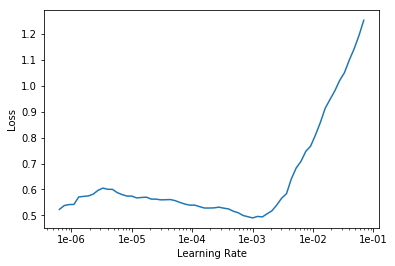

In [90]:
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-4))

In [0]:
learn.save('stage-2')

## Evaluate model

The model reached an accuracy of 72.83% (error rate of 0.271654) on the validation set. 

The model is most confused between cottage and house and between town hall and church. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

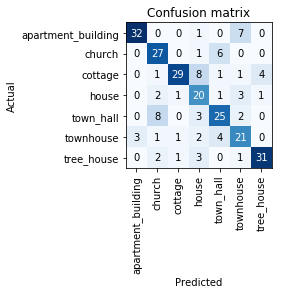

In [94]:
interp.plot_confusion_matrix()

In [95]:
interp.most_confused(min_val=2)

[('cottage', 'house', 8),
 ('town_hall', 'church', 8),
 ('apartment_building', 'townhouse', 7),
 ('church', 'town_hall', 6),
 ('cottage', 'tree_house', 4),
 ('townhouse', 'town_hall', 4),
 ('house', 'townhouse', 3),
 ('town_hall', 'house', 3),
 ('townhouse', 'apartment_building', 3),
 ('tree_house', 'house', 3),
 ('house', 'church', 2),
 ('town_hall', 'townhouse', 2),
 ('townhouse', 'house', 2),
 ('tree_house', 'church', 2)]

In [0]:
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [97]:
learn = create_cnn(data2, models.resnet34, pretrained=False).load('stage-2')

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Here I test the model on 3 places that I have lived in previously in Germany and Australia: a house, a townhouse, and an apartment building, identified by the model as a cottage, a townhouse, and an apartment building. The only incorrect classification being the house as a cottage, which can be explained by many of the houses in the dataset being more modern than this house.

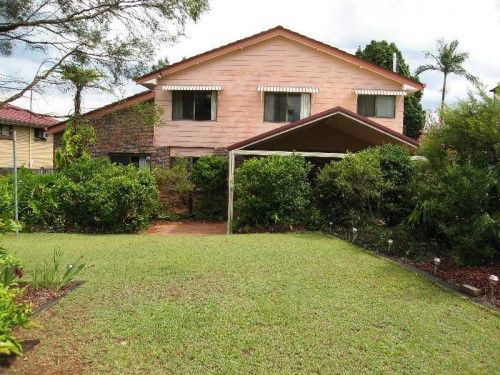

In [110]:
img = open_image('house_australia.jpg')
img

In [111]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category cottage

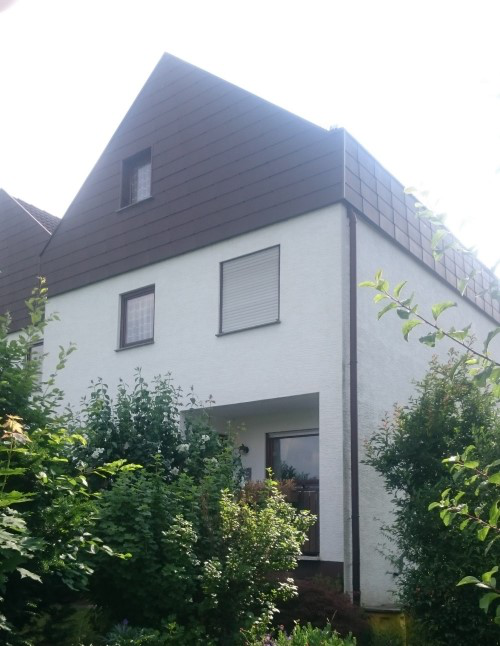

In [100]:
img = open_image('house_germany.jpg')
img

In [101]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category townhouse

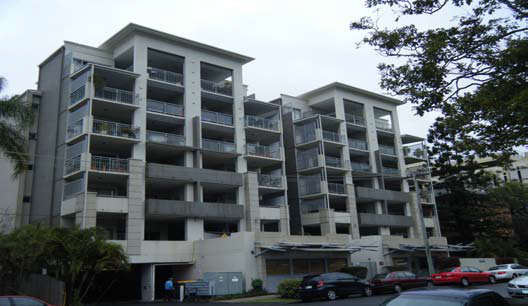

In [102]:
img = open_image('apartment_building.jpg')
img

In [103]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category apartment_building

Here I test the model on the town halls of 3 cities I have lived in:

Brisbane City Hall, identified by the model as a church.

By Kgbo - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=29964655

Boston City Hall, identified by the model as a town hall.

By Daderot - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=75886193

Stuttgart Rathaus, identified by the model as an apartment building.

By Joachim Köhler - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1304013

Town halls are quite diverse building styles, so it is not suprising that the model is confused about the category for these buildings. In particular, the Brisbane City Hall has a clocktower that looks like the tower on many churches, and the Stuttgart Rathaus has many windows that look like an apartment building.

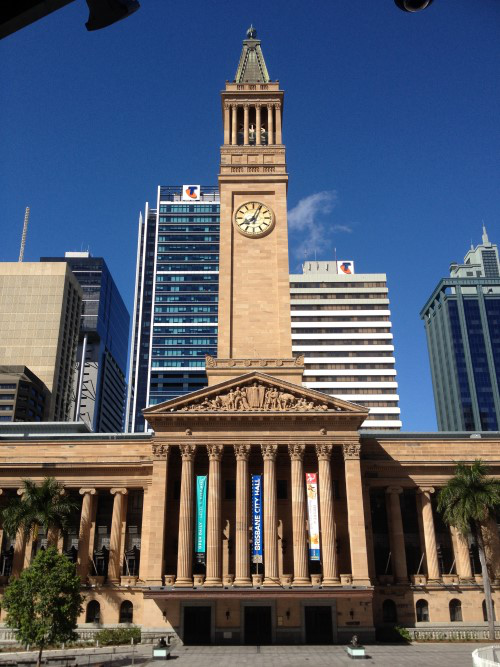

In [104]:
img = open_image('King_George_Square_in_12.2013_07.jpg')
img

In [105]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category church

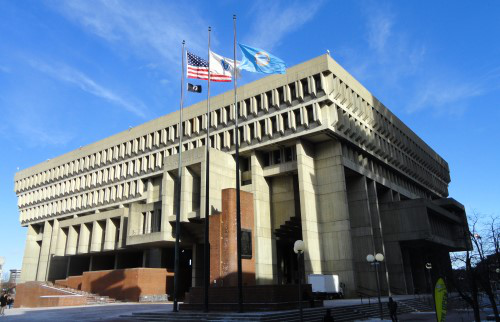

In [106]:
img = open_image('Boston_City_Hall_-_Boston,_MA_-_DSC04704_(cropped).JPG')
img

In [107]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category town_hall

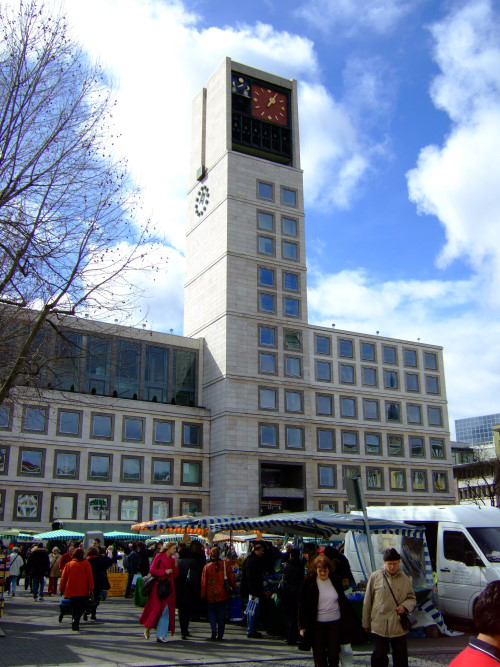

In [108]:
img = open_image('Stuttgart_Rathaus01.JPG')
img

In [109]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category apartment_building

## Conclusions

Using the techniques described in the fastai course, it was fairly straightforward to build a dataset of images and train a model to classify those images. The model trained here reached an accuracy of 72.83% (error rate of 0.271654) on the validation set. This would likely be higher if images that were not relevant were deleted.
